In [33]:
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
from torchvision import datasets,transforms
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image

In [34]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [35]:
DATA_DIR = "data"

In [36]:
PROCESS_DATA = 1
TRAINING_DATA = 0

In [37]:
IMG_SIZE = 64
BATCH_SIZE = 64
LATENT_SIZE = 100

In [38]:
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [39]:
if PROCESS_DATA:
    dataset = datasets.ImageFolder(DATA_DIR, transform= data_transform)
    dataloader = data.DataLoader(dataset,batch_size=BATCH_SIZE, num_workers=4, shuffle=True)

In [40]:
#Show data size
print(len(dataset))

21551


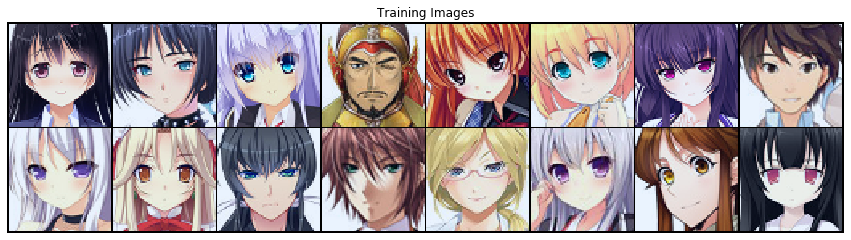

In [41]:
#Visualize some training data
def visualize_data(dataloader, NUM_PIC=16):
    a = np.random.randint(BATCH_SIZE-NUM_PIC)
    fig = plt.figure(figsize=(15,15))
    img = next(iter(dataloader))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(img[0][a:a+NUM_PIC],padding=1, normalize=True),(1,2,0)))
    plt.show()

visualize_data(dataloader)

In [42]:
#Make random latent noise vector
def random_noise(size):
    noise = torch.randn(size, LATENT_SIZE, 1 , 1)
    return Variable(noise).to(device)

In [43]:
#Generate truth or false label
def generate_label(size,label):
    if label:
        data = torch.ones(size,1) - 0.1 #Smooth label one-side
    else:
        data = torch.zeros(size,1)
    return Variable(data).view(-1).to(device)

In [44]:
#Inititate weights for Generator and Discriminator with mean = 0.02, standard deviation = 1
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [45]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,128*8,4,1,0),
            nn.BatchNorm2d(128*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(128*8,128*4,4,2,1),
            nn.BatchNorm2d(128*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(128*4,128*2,4,2,1),
            nn.BatchNorm2d(128*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(128*2,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128,3,4,2,1),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.main(x)
        return x

In [46]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 128*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128*2, 128*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128*4, 128*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [47]:
#Train the discriminator
def train_discriminator(D, D_optimizer, error, real_data, fake_data):
    batch_size = real_data.size(0)
    D_optimizer.zero_grad()
    
    #Training on all real data
    real_data = real_data.to(device)
    predict_real = D(real_data).view(-1)
    real_label = generate_label(batch_size, 1)
    loss_real = error(predict_real,real_label)
    loss_real.backward()
    
    
    #Training on all fake data
    fake_data = fake_data.to(device)
    predict_fake = D(fake_data).view(-1)
    fake_label = generate_label(batch_size, 0)
    loss_fake = error(predict_fake, fake_label)
    loss_fake.backward()
    
    D_x = predict_real.mean().item()
    D_g_z1 = predict_fake.mean().item()
    
    D_optimizer.step()
    
    return loss_real.data+loss_fake.data, D_x, D_g_z1
    

In [48]:
#Train the generator
def train_generator(D, G_optimizer, error, fake_data):
    batch_size = fake_data.size(0)
    G_optimizer.zero_grad()
    fake_data = fake_data.to(device)
    predict = D(fake_data).view(-1)
    real_label = generate_label(batch_size, 1)
    loss = error(predict, real_label)
    loss.backward()
    G_optimizer.step()
    D_g_z2 = predict.mean().item()
    return loss.data, D_g_z2

In [49]:
#Generate some samples
def generate_samples(G, noise):
    G.eval()
    with torch.no_grad():
        fig = plt.figure(figsize=(15,10))
        generated = G(noise).detach().view(-1,3,IMG_SIZE,IMG_SIZE).cpu()
        img = np.transpose(torchvision.utils.make_grid(generated[:],padding =1, normalize=True),(1,2,0))
        plt.imshow(img)
        plt.axis("off")
        plt.title("Generated Images")
        plt.show()
    G.train()

In [50]:
#Generate fixed test noise
test_noise = random_noise(16)

In [51]:
#Start training process
def train(D, G, D_optimizer, G_optimizer, error, dataloader):
    EPOCHS = 70
    D_loss_list = []
    G_loss_list = []
    print("Start Training.....")
    for epoch in range(EPOCHS):
        for i, (real_batch,_) in enumerate(dataloader):
            #First train the Discriminator
            batch_size = real_batch.size(0)
            real_data = Variable(real_batch.view(-1,3,IMG_SIZE,IMG_SIZE))
            fake_data = G(random_noise(batch_size)).detach()
            D_loss, D_x, D_g_z1 = train_discriminator(D, D_optimizer, error, real_data, fake_data)
            
            #Then train the Generator
            data = G(random_noise(batch_size))
            G_loss, D_g_z2 = train_generator(D, G_optimizer, error, data)
            
            D_loss_list.append(D_loss)
            G_loss_list.append(G_loss)
            
            if i%100==0:
                print("Epoch: ({}/{}), Batch: ({}/{}), D_Loss: {:.4f}, G_Loss: {:.4f}, D(x): {:.4f}, G(D(z)): {:.4f} / {:.4f}".format(epoch+1,EPOCHS,i,len(dataloader),D_loss,G_loss,D_x, D_g_z1,D_g_z2))
        torch.save(G.state_dict(), "model/generator.pth")
        torch.save(D.state_dict(), "model/discriminator.pth")
        if epoch%10==0 or epoch == EPOCHS-1:
            generate_samples(G, test_noise)
    print("Training Completed!")
    return G, D_loss_list, G_loss_list

Start Training.....
Epoch: (1/70), Batch: (0/337), D_Loss: 1.8957, G_Loss: 6.8694, D(x): 0.4152, G(D(z)): 0.3858 / 0.0021
Epoch: (1/70), Batch: (100/337), D_Loss: 0.6145, G_Loss: 37.7040, D(x): 0.8978, G(D(z)): 0.0000 / 0.0000
Epoch: (1/70), Batch: (200/337), D_Loss: 0.3445, G_Loss: 60.1045, D(x): 0.8663, G(D(z)): 0.0000 / 0.0000
Epoch: (1/70), Batch: (300/337), D_Loss: 0.4273, G_Loss: 56.6350, D(x): 0.9485, G(D(z)): 0.0000 / 0.0000


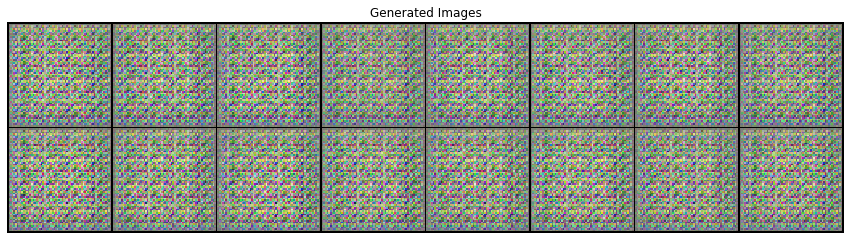

Epoch: (2/70), Batch: (0/337), D_Loss: 0.3327, G_Loss: 55.4856, D(x): 0.8961, G(D(z)): 0.0000 / 0.0000
Epoch: (2/70), Batch: (100/337), D_Loss: 0.3314, G_Loss: 53.7594, D(x): 0.9171, G(D(z)): 0.0000 / 0.0000
Epoch: (2/70), Batch: (200/337), D_Loss: 0.3288, G_Loss: 52.1164, D(x): 0.8904, G(D(z)): 0.0000 / 0.0000
Epoch: (2/70), Batch: (300/337), D_Loss: 0.3488, G_Loss: 50.6459, D(x): 0.8688, G(D(z)): 0.0000 / 0.0000
Epoch: (3/70), Batch: (0/337), D_Loss: 0.3279, G_Loss: 50.3011, D(x): 0.9113, G(D(z)): 0.0000 / 0.0000
Epoch: (3/70), Batch: (100/337), D_Loss: 0.3370, G_Loss: 48.0880, D(x): 0.8723, G(D(z)): 0.0000 / 0.0000
Epoch: (3/70), Batch: (200/337), D_Loss: 0.3467, G_Loss: 46.9629, D(x): 0.9279, G(D(z)): 0.0000 / 0.0000
Epoch: (3/70), Batch: (300/337), D_Loss: 0.3317, G_Loss: 46.4460, D(x): 0.8792, G(D(z)): 0.0000 / 0.0000
Epoch: (4/70), Batch: (0/337), D_Loss: 0.3290, G_Loss: 45.8612, D(x): 0.8994, G(D(z)): 0.0000 / 0.0000
Epoch: (4/70), Batch: (100/337), D_Loss: 0.3365, G_Loss: 45.1

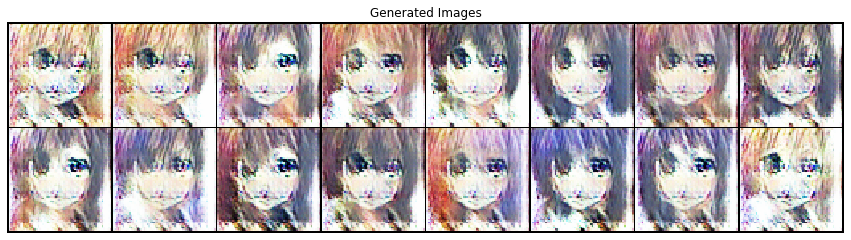

Epoch: (12/70), Batch: (0/337), D_Loss: 0.5090, G_Loss: 4.0575, D(x): 0.7892, G(D(z)): 0.0498 / 0.0171
Epoch: (12/70), Batch: (100/337), D_Loss: 0.7020, G_Loss: 2.3743, D(x): 0.6520, G(D(z)): 0.0832 / 0.1127
Epoch: (12/70), Batch: (200/337), D_Loss: 0.7894, G_Loss: 5.0009, D(x): 0.8965, G(D(z)): 0.3063 / 0.0052
Epoch: (12/70), Batch: (300/337), D_Loss: 1.0137, G_Loss: 2.9622, D(x): 0.4892, G(D(z)): 0.0279 / 0.0519
Epoch: (13/70), Batch: (0/337), D_Loss: 0.8916, G_Loss: 6.6191, D(x): 0.9517, G(D(z)): 0.2983 / 0.0016
Epoch: (13/70), Batch: (100/337), D_Loss: 0.6416, G_Loss: 2.6384, D(x): 0.7152, G(D(z)): 0.0831 / 0.0737
Epoch: (13/70), Batch: (200/337), D_Loss: 1.2913, G_Loss: 11.6129, D(x): 0.9175, G(D(z)): 0.5199 / 0.0000
Epoch: (13/70), Batch: (300/337), D_Loss: 0.6089, G_Loss: 4.1437, D(x): 0.8218, G(D(z)): 0.1446 / 0.0135
Epoch: (14/70), Batch: (0/337), D_Loss: 0.8042, G_Loss: 5.6258, D(x): 0.8636, G(D(z)): 0.2906 / 0.0030
Epoch: (14/70), Batch: (100/337), D_Loss: 0.9081, G_Loss: 1.

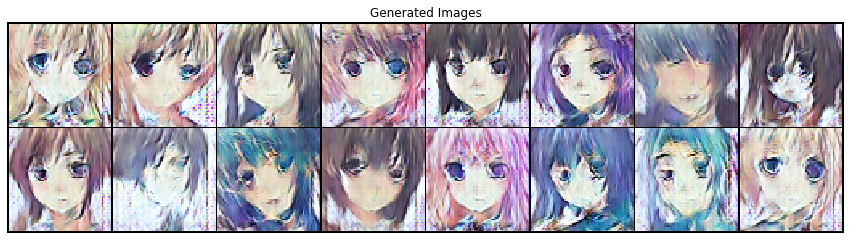

Epoch: (22/70), Batch: (0/337), D_Loss: 0.7772, G_Loss: 4.7996, D(x): 0.8573, G(D(z)): 0.2868 / 0.0077
Epoch: (22/70), Batch: (100/337), D_Loss: 0.6137, G_Loss: 2.1821, D(x): 0.6587, G(D(z)): 0.0612 / 0.1199
Epoch: (22/70), Batch: (200/337), D_Loss: 1.0249, G_Loss: 2.8722, D(x): 0.4433, G(D(z)): 0.0198 / 0.0768
Epoch: (22/70), Batch: (300/337), D_Loss: 0.5665, G_Loss: 2.6362, D(x): 0.7098, G(D(z)): 0.0548 / 0.0850
Epoch: (23/70), Batch: (0/337), D_Loss: 0.5934, G_Loss: 4.9059, D(x): 0.8224, G(D(z)): 0.1510 / 0.0102
Epoch: (23/70), Batch: (100/337), D_Loss: 0.4807, G_Loss: 2.8742, D(x): 0.7822, G(D(z)): 0.0509 / 0.0661
Epoch: (23/70), Batch: (200/337), D_Loss: 0.5010, G_Loss: 3.3237, D(x): 0.7829, G(D(z)): 0.0620 / 0.0374
Epoch: (23/70), Batch: (300/337), D_Loss: 0.5473, G_Loss: 2.8780, D(x): 0.7723, G(D(z)): 0.0944 / 0.0525
Epoch: (24/70), Batch: (0/337), D_Loss: 0.6786, G_Loss: 2.7526, D(x): 0.6137, G(D(z)): 0.0359 / 0.0823
Epoch: (24/70), Batch: (100/337), D_Loss: 0.5862, G_Loss: 4.3

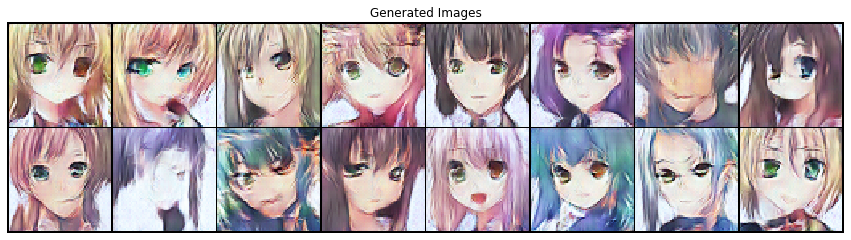

Epoch: (32/70), Batch: (0/337), D_Loss: 0.6073, G_Loss: 1.9106, D(x): 0.6729, G(D(z)): 0.0481 / 0.1931
Epoch: (32/70), Batch: (100/337), D_Loss: 0.5312, G_Loss: 3.7988, D(x): 0.8320, G(D(z)): 0.1265 / 0.0262
Epoch: (32/70), Batch: (200/337), D_Loss: 0.7090, G_Loss: 1.2584, D(x): 0.5787, G(D(z)): 0.0255 / 0.3387
Epoch: (32/70), Batch: (300/337), D_Loss: 0.5369, G_Loss: 4.4828, D(x): 0.9321, G(D(z)): 0.1369 / 0.0097
Epoch: (33/70), Batch: (0/337), D_Loss: 0.6122, G_Loss: 2.0281, D(x): 0.6573, G(D(z)): 0.0536 / 0.1710
Epoch: (33/70), Batch: (100/337), D_Loss: 0.6686, G_Loss: 1.5818, D(x): 0.5977, G(D(z)): 0.0208 / 0.2430
Epoch: (33/70), Batch: (200/337), D_Loss: 0.8304, G_Loss: 5.2113, D(x): 0.9584, G(D(z)): 0.3144 / 0.0076
Epoch: (33/70), Batch: (300/337), D_Loss: 0.4869, G_Loss: 3.2219, D(x): 0.7981, G(D(z)): 0.0800 / 0.0445
Epoch: (34/70), Batch: (0/337), D_Loss: 0.5060, G_Loss: 3.8136, D(x): 0.8247, G(D(z)): 0.0843 / 0.0265
Epoch: (34/70), Batch: (100/337), D_Loss: 0.5378, G_Loss: 3.7

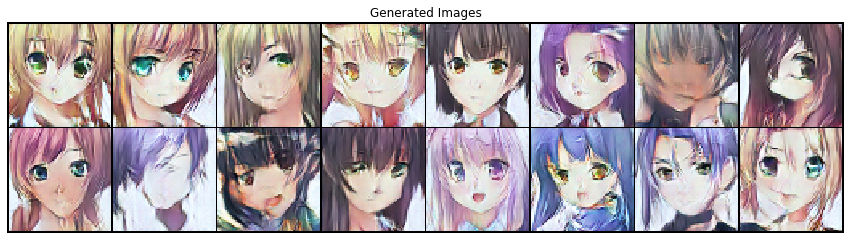

Epoch: (42/70), Batch: (0/337), D_Loss: 0.6543, G_Loss: 4.8174, D(x): 0.9434, G(D(z)): 0.2198 / 0.0094
Epoch: (42/70), Batch: (100/337), D_Loss: 0.6087, G_Loss: 3.2106, D(x): 0.7260, G(D(z)): 0.0931 / 0.0468
Epoch: (42/70), Batch: (200/337), D_Loss: 0.5282, G_Loss: 2.7439, D(x): 0.8431, G(D(z)): 0.1315 / 0.0735
Epoch: (42/70), Batch: (300/337), D_Loss: 1.9959, G_Loss: 0.4873, D(x): 0.1920, G(D(z)): 0.0005 / 0.7488
Epoch: (43/70), Batch: (0/337), D_Loss: 0.7086, G_Loss: 2.5226, D(x): 0.5818, G(D(z)): 0.0225 / 0.0867
Epoch: (43/70), Batch: (100/337), D_Loss: 0.5161, G_Loss: 3.2908, D(x): 0.9209, G(D(z)): 0.1228 / 0.0431
Epoch: (43/70), Batch: (200/337), D_Loss: 0.5753, G_Loss: 3.4998, D(x): 0.9240, G(D(z)): 0.1662 / 0.0431
Epoch: (43/70), Batch: (300/337), D_Loss: 0.4487, G_Loss: 4.0250, D(x): 0.8009, G(D(z)): 0.0386 / 0.0209
Epoch: (44/70), Batch: (0/337), D_Loss: 1.3348, G_Loss: 5.5048, D(x): 0.9947, G(D(z)): 0.4885 / 0.0046
Epoch: (44/70), Batch: (100/337), D_Loss: 0.4764, G_Loss: 3.2

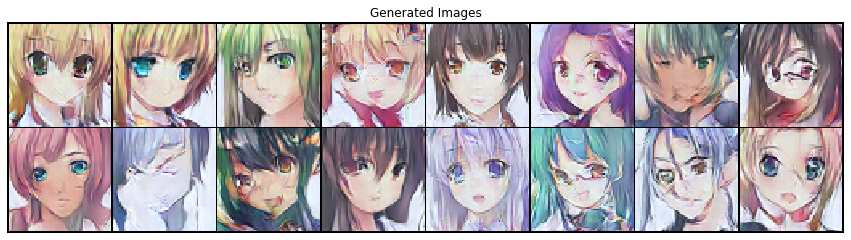

Epoch: (52/70), Batch: (0/337), D_Loss: 0.7285, G_Loss: 1.8398, D(x): 0.5699, G(D(z)): 0.0332 / 0.2044
Epoch: (52/70), Batch: (100/337), D_Loss: 0.6865, G_Loss: 1.2682, D(x): 0.5739, G(D(z)): 0.0193 / 0.3122
Epoch: (52/70), Batch: (200/337), D_Loss: 0.3970, G_Loss: 4.3755, D(x): 0.8912, G(D(z)): 0.0436 / 0.0124
Epoch: (52/70), Batch: (300/337), D_Loss: 0.5249, G_Loss: 3.0261, D(x): 0.6884, G(D(z)): 0.0200 / 0.0616
Epoch: (53/70), Batch: (0/337), D_Loss: 0.4593, G_Loss: 4.2751, D(x): 0.9233, G(D(z)): 0.0914 / 0.0153
Epoch: (53/70), Batch: (100/337), D_Loss: 0.4987, G_Loss: 2.2940, D(x): 0.7695, G(D(z)): 0.0515 / 0.1170
Epoch: (53/70), Batch: (200/337), D_Loss: 0.6001, G_Loss: 2.6326, D(x): 0.6617, G(D(z)): 0.0283 / 0.0955
Epoch: (53/70), Batch: (300/337), D_Loss: 0.4568, G_Loss: 3.5937, D(x): 0.8946, G(D(z)): 0.0761 / 0.0304
Epoch: (54/70), Batch: (0/337), D_Loss: 0.4339, G_Loss: 3.3603, D(x): 0.8589, G(D(z)): 0.0507 / 0.0375
Epoch: (54/70), Batch: (100/337), D_Loss: 0.5030, G_Loss: 2.3

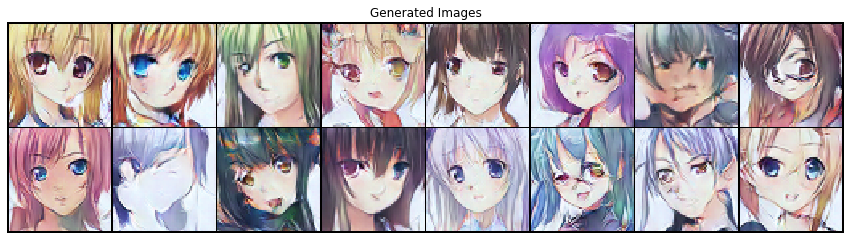

Epoch: (62/70), Batch: (0/337), D_Loss: 0.4441, G_Loss: 4.7538, D(x): 0.9455, G(D(z)): 0.0676 / 0.0094
Epoch: (62/70), Batch: (100/337), D_Loss: 0.5531, G_Loss: 2.6572, D(x): 0.6433, G(D(z)): 0.0062 / 0.0919
Epoch: (62/70), Batch: (200/337), D_Loss: 0.5458, G_Loss: 3.5607, D(x): 0.7131, G(D(z)): 0.0568 / 0.0337
Epoch: (62/70), Batch: (300/337), D_Loss: 0.4321, G_Loss: 3.6408, D(x): 0.7964, G(D(z)): 0.0268 / 0.0392
Epoch: (63/70), Batch: (0/337), D_Loss: 0.4331, G_Loss: 3.7391, D(x): 0.8164, G(D(z)): 0.0315 / 0.0257
Epoch: (63/70), Batch: (100/337), D_Loss: 0.4258, G_Loss: 2.8097, D(x): 0.9115, G(D(z)): 0.0571 / 0.0678
Epoch: (63/70), Batch: (200/337), D_Loss: 0.7990, G_Loss: 0.8895, D(x): 0.5201, G(D(z)): 0.0115 / 0.4635
Epoch: (63/70), Batch: (300/337), D_Loss: 0.7168, G_Loss: 2.0151, D(x): 0.5787, G(D(z)): 0.0204 / 0.1722
Epoch: (64/70), Batch: (0/337), D_Loss: 0.3994, G_Loss: 4.3164, D(x): 0.8712, G(D(z)): 0.0264 / 0.0147
Epoch: (64/70), Batch: (100/337), D_Loss: 0.5076, G_Loss: 1.9

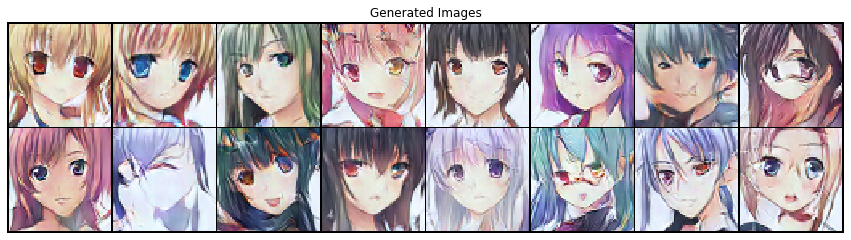

Training Completed!


In [20]:
D = Discriminator().to(device)
G = Generator().to(device)
D.apply(weights_init)
G.apply(weights_init)

if TRAINING_DATA:
    D_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002, betas= (0.5, 0.999))
    G_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))
    error = nn.BCELoss()
    G, D_loss_list, G_loss_list = train(D, G, D_optimizer, G_optimizer, error, dataloader)

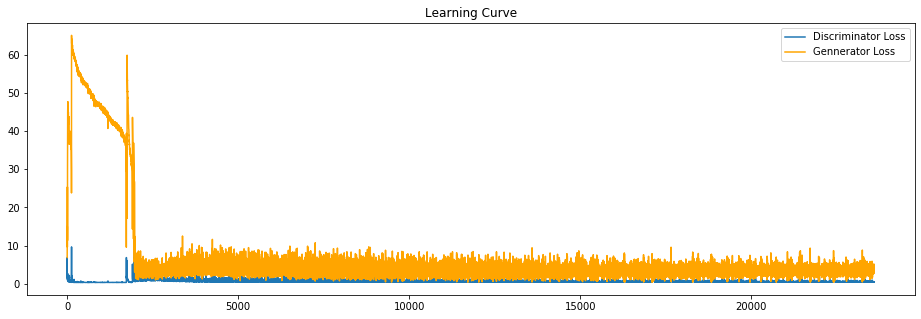

In [21]:
#Plot learning curves
def plot(D_loss_list, G_loss_list, EPOCHS=None):
    if EPOCHS is None:
        EPOCHS = len(D_loss_list)
    fig = plt.figure(figsize=(35,5))
    fig.add_subplot(1,2,1)
    plt.plot(range(EPOCHS), D_loss_list,label = "Discriminator Loss")
    plt.plot(range(EPOCHS),G_loss_list, color ="orange",label = "Gennerator Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()
if TRAINING_DATA: 
    plot(D_loss_list, G_loss_list)

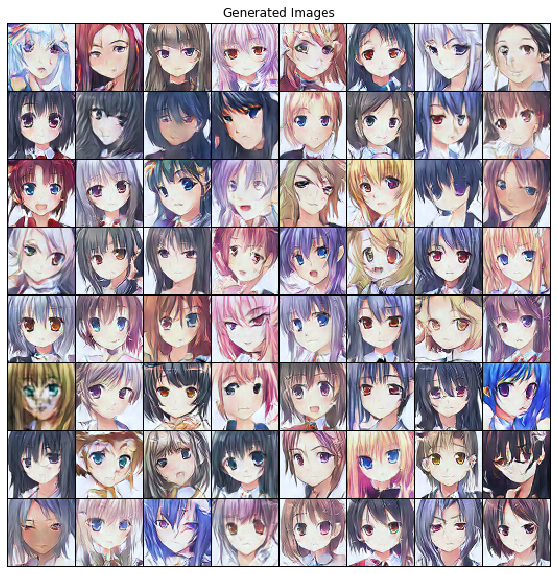

In [56]:
if not TRAINING_DATA:
    G.load_state_dict(torch.load("model/generator-sota.pth"))

#Generate final samples
def visualize_final(NUM_PIC=16):
    test_noise = random_noise(NUM_PIC)
    generate_samples(G, test_noise)
visualize_final(64)